# Build temporal network of PPI with gene expression data from RNA-seq

Here, we build a temporal network of protein-protein interactions (PPI) for the cell cycle of budding yeast, by integrating time series data about gene expression to a static network of PPI.

In [1]:
import string
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

import phasik as pk

outdir = "../data/mouse"
Path(outdir).mkdir(parents=True, exist_ok=True)

## 1. Load static network

In [2]:
static_net_filepath = "../data/mouse/extendedCC_STRING_onlyOneWayIndicated.tsv"

edge_list = pd.read_csv(static_net_filepath, delimiter="\t")[["#node1", "node2"]]

static_network = nx.Graph()
static_network.add_edges_from(edge_list.values)

pk.graph_size_info(static_network)

'609 nodes and 6219 edges'

In [3]:
# list of genes used in the paper
genes_kegg = pd.read_excel("../data/mouse/12859_2019_2895_MOESM1_ESM.xlsx")[
    "Gene Symbol"
].tolist()
print(f"{len(genes_kegg)} genes in KEGG list")

# restrict our static network to those genes
nodes_not_kegg = list(set(static_network.nodes).difference(genes_kegg))
static_network.remove_nodes_from(nodes_not_kegg)

pk.graph_size_info(static_network)

63 genes in KEGG list


'61 nodes and 308 edges'

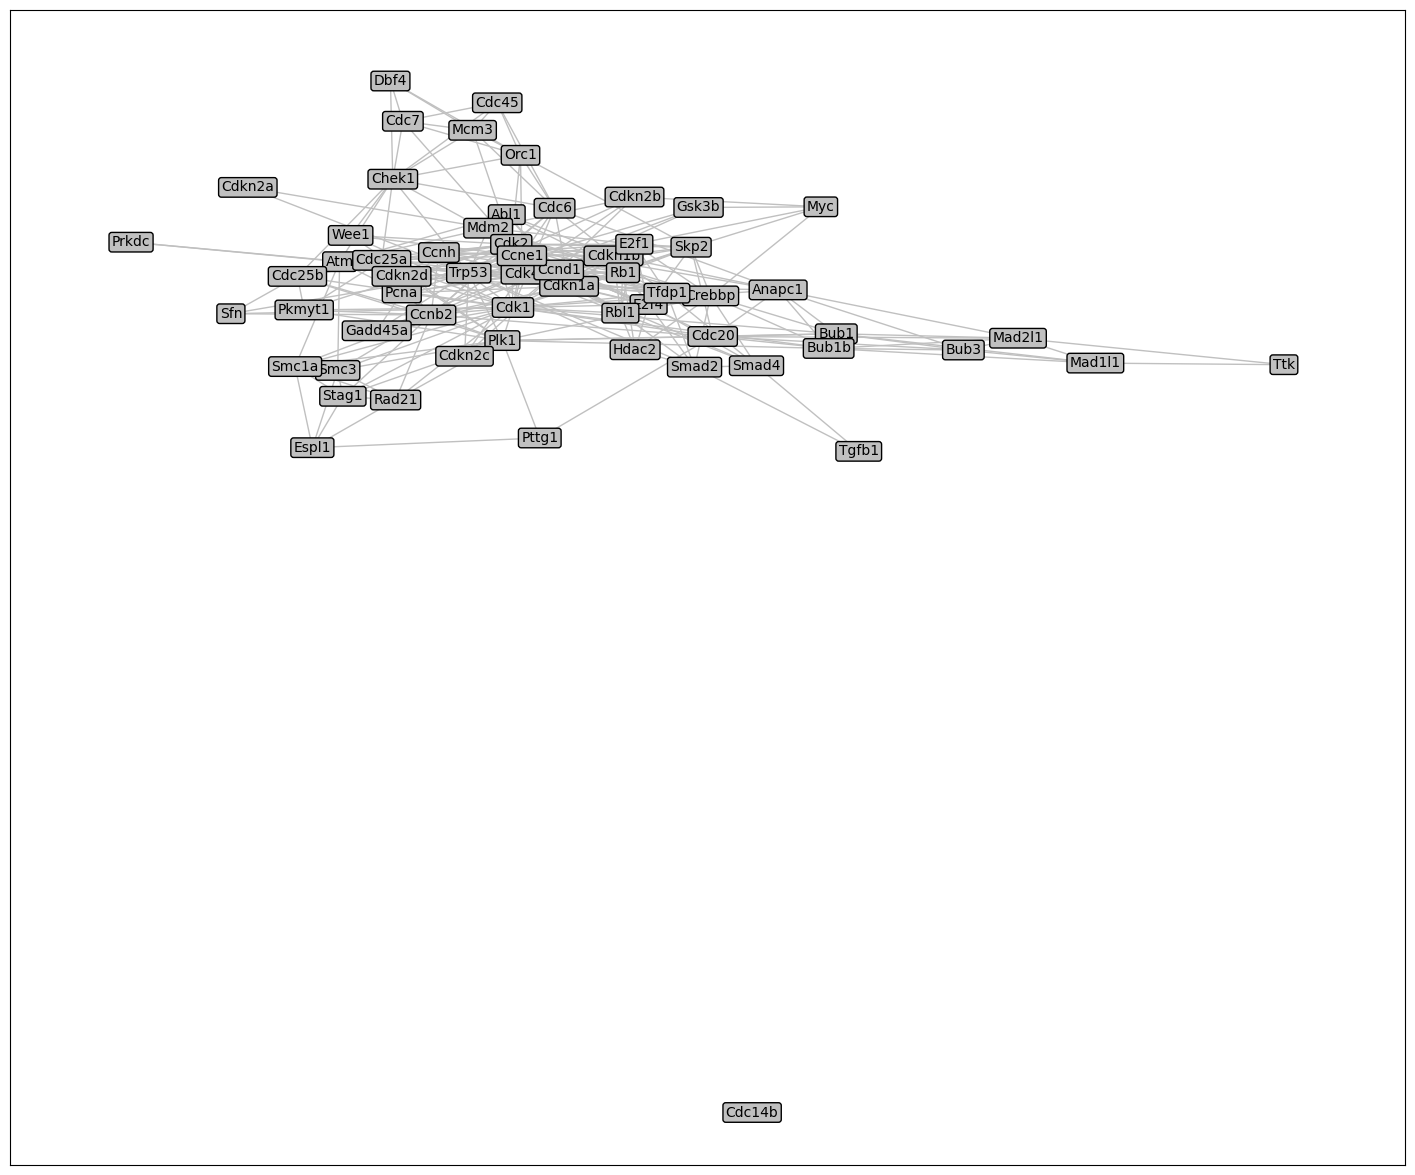

In [5]:
# plot static PPI network
fig, ax = plt.subplots(figsize=(18, 15))

pk.draw_graph(static_network, ax=ax, color="silver")
plt.show()

## 2. Load and format temporal data

### 2.1 Visualise all time points

In [6]:
node_table_filepath = "../data/mouse/nonredun_Filter.txt"

n1 = 64  # number of times in cycle 1

node_series = pd.read_csv(
    node_table_filepath, sep="\t", index_col="Gene Symbol"
)  # , skipfooter=1, engine='python')
node_series = node_series.iloc[:, :n1]

# uncomment if we want only the first i_end timepoints
# i_start = 3
# i_end = 23
# node_table = node_table.iloc[:, i_start:i_end]

# n_times = node_series.shape[1]
times = list(node_series.columns)

times[times.index("c1_27")] = "c1_27h"
times[times.index("c12.5h")] = "c1_12.5h"

times = [i.split("_")[-1][:-1] for i in times]
# times[0] = '0h'
# times[-1] = '100h'
# times = [int(t[:-1]) for t in times]
# times

# c12.5h
times = [float(i) for i in times]
node_series.columns = times

# node_table.columns = ['ID'] + times.tolist()

node_series

-1.0          0.0          1.0          1.5          2.0   \
Gene Symbol                                                                  
Marc1           1.5030     0.912000     1.859000     0.000000     0.000000   
March1          1.5030     3.647000     5.576000     4.682000    14.239000   
March2        426.8510   419.417000   388.450000   305.119000   278.142000   
Marc2         664.3250   591.743000   635.645000   503.329000   494.580000   
March2        216.9330   230.375667   197.322667   161.793667   130.052667   
...                ...          ...          ...          ...          ...   
Zxdc          191.6325   172.781500   186.325500   292.633000   287.160000   
Zyg11b        754.5040   880.775000   591.968000   607.896000   332.251000   
Zyx          2134.2550  2483.677000  3904.013000  3940.792000  4545.200000   
Zzef1         450.8990   482.329000   374.510000   297.315000   250.613000   
Zzz3          784.5640   799.171500   609.624000   599.312000   460.406000   

                    2.5          3.0          3.5          4.0          4.5   \
Gene Symbol                                                                    
Marc1           0.840000     0.000000     0.000000     0.000000     1.485000   
March1          8.403000     9.359000    15.617000     8.873000    11.879000   
March2        240.327000   192.214000   184.116000   173.756000   165.561000   
Marc2         444.521000   380.108000   307.409000   318.677000   290.288000   
March2        113.161333   105.345667   101.647333    86.261667    91.813333   
...                  ...          ...          ...          ...          ...   
Zxdc          281.922000   208.051500   174.664000   188.914000   181.151500   
Zyg11b        292.426000   313.158000   450.428000   413.319000   442.485000   
Zyx          4578.817000  4224.387000  4418.794000  5163.155000  6701.129000   
Zzef1         281.502000   315.317000   475.908000   459.900000   627.349000   
Zzz3          479.814000   526.249000   577.008000   622.196000   653.334000   

             ...          29.0          30.0          31.0       32.0  \
Gene Symbol  ...                                                        
Marc1        ...      3.903000      2.826000      2.818000      0.000   
March1       ...      1.952000      3.767000      6.889333      4.453   
March2       ...    275.181000    297.621000    299.683000    273.412   
Marc2        ...    466.441000    588.649000    527.028000    505.856   
March2       ...    148.649667    144.101333    143.735000    124.089   
...          ...           ...           ...           ...        ...   
Zxdc         ...    154.179000    161.996500    167.221000    158.971   
Zyg11b       ...    421.553000    416.293000    375.778000    406.110   
Zyx          ...  11746.894000  12159.136000  13559.005000  12160.149   
Zzef1        ...   1020.705000    846.713000    896.230000    895.936   
Zzz3         ...    730.888000    700.257000    682.037000    698.224   

                  33.0         34.0         35.0         36.0      37.0  \
Gene Symbol                                                               
Marc1           3.6140     1.661000     1.959000     5.407000     3.895   
March1          6.0240     6.368000     1.959000     7.208667     4.869   
March2        226.4930   238.373000   354.510000   321.159000   320.403   
Marc2         407.2060   439.370000   601.296000   561.217000   543.420   
March2        124.4910   125.969667   169.094333   177.340333   170.752   
...                ...          ...          ...          ...       ...   
Zxdc          122.8845   142.027000   192.924000   232.488500   212.304   
Zyg11b        519.2480   641.198000   497.489000   631.504000   733.324   
Zyx          9407.9080  8956.012000  7789.428000  5886.828000  5195.599   
Zzef1        1158.9710   963.459000   736.441000   947.256000   922.255   
Zzz3          866.2170   774.089000   620.882000   720.174000   729.429   

                  38.0  
Gene Symbo

In [7]:
mask_downsample = [i.is_integer() for i in times]
mask_kegg = [(i in genes_kegg) for i in node_series.index]

node_series = node_series.iloc[mask_kegg, mask_downsample]
node_series

-1.0        0.0        1.0        2.0        3.0        4.0   \
Gene Symbol                                                                     
Abl1         1533.0570  1543.1805   991.1045   512.1420   807.0105  1288.3855   
Anapc1       1914.8180  2093.4370  1341.9170   913.2170  1025.1410  1282.8400   
Atm           377.2520   386.5930   241.6190   114.8640   128.8630   184.8470   
Bub1          223.9470   229.7680   186.7900   100.6250    59.7520    54.7150   
Bub1b         413.3240   406.6520   358.7120   141.4440    82.7890   113.8660   
...                ...        ...        ...        ...        ...        ...   
Tfdp1         437.3720   369.2690   264.8520   284.7870   435.5410   488.7360   
Tgfb1         300.5990   309.0920   655.1600  2021.0380  3124.3760  3004.8780   
Trp53         979.9540   841.5690   873.0825   862.9045   978.3475   960.0970   
Ttk           130.0095   147.7075    76.2030    45.0915    29.5160    31.4240   
Wee1          228.4560   208.7970   179.3560    86.3850   172.0570   160.4470   

                 5.0       6.0        7.0        8.0   ...      29.0  \
Gene Symbol                                            ...             
Abl1         1719.675  2106.656  1912.6475  1959.7325  ...  1804.775   
Anapc1       1536.455  1667.125  1487.5560  1829.7410  ...  2200.469   
Atm           169.002   240.368   151.0960   230.4120  ...   435.215   
Bub1           69.876    68.677    62.7800    81.3220  ...   797.243   
Bub1b         129.189   130.486   130.8790   129.3760  ...   944.592   
...               ...       ...        ...        ...  ...       ...   
Tfdp1         541.944   638.693   520.3250   664.1280  ...   815.784   
Tgfb1        3436.101  3241.537  3416.6960  2485.2440  ...   647.943   
Trp53        1142.794  1018.131  1172.0620  1134.1930  ...  1483.243   
Ttk            42.657    54.941    49.4790    52.9825  ...   360.565   
Wee1          192.565   175.125   143.6480   187.2870  ...   442.045   

                  30.0       31.0      32.0       33.0       34.0       35.0  \
Gene Symbol                                                                    
Abl1         1577.1085  1566.5240  1493.078  1549.9135  1374.1745  1223.1575   
Anapc1       2014.5930  2183.2700  2109.813  2673.3450  2735.8900  2559.9150   
Atm           372.9680   390.8090   387.408   597.5570   591.3640   503.3650   
Bub1          714.8550   705.5230   845.172   893.9260   899.5050   955.8060   
Bub1b         926.7690   968.5670  1088.304  1104.7580  1237.5460  1584.5230   
...                ...        ...       ...        ...        ...        ...   
Tfdp1         823.1670   729.0090   860.312   901.1540   866.2820   718.8130   
Tgfb1         584.8820   663.2480   530.793   409.6160   528.2410   511.2000   
Trp53        1517.7730  1531.2945  1458.345  1253.5440  1417.3640  1576.6885   
Ttk           358.8405   387.5210   434.609   507.2005   505.4005   572.8960   
Wee1          411.5830   418.9920   408.782   369.8590   583.0590   489.6550   

                  36.0       37.0       38.0  
Gene Symbol                                   
Abl1         1332.7545  1285.5090  1274.4235  
Anapc1       2864.4760  3045.2930  2889.8240  
Atm           610.9580   598.9300   583.9930  
Bub1         1059.7160  1162.8010  1115.2380  
Bub1b        1789.6220  1818.2160  1540.9880  
...                ...        ...        ...  
Tfdp1         760.1840   669.0490   693.2560  
Tgfb1         356.8430   308.7170   369.2340  
Trp53        1172.7160  1105.3430  1178.3475  
Ttk           667.7290   643.2415   594.3545  
Wee1          479.0350   454.7980   438.9370  

[62 rows x 40 columns]

In [23]:
# # restrict to times from 5h-29h
mask_time = (node_series.columns >= 5) & (node_series.columns <= 29)
node_series = node_series.iloc[:, mask_time]
# node_series

In [24]:
# times series for 2nd cell cycle
node_series_2 = pd.read_csv(
    node_table_filepath, sep="\t", index_col="Gene Symbol"
).iloc[:, 64:]

times_2 = list(node_series_2.columns)
times_2 = [i.split("_")[-1][:-1] for i in times_2]
times_2 = [float(i) for i in times_2]

node_series_2.columns = times_2

mask_downsample_2 = [i.is_integer() for i in times_2]
mask_kegg_2 = [(i in genes_kegg) for i in node_series_2.index]

node_series_2 = node_series_2.iloc[mask_kegg_2, mask_downsample_2]
node_series_2

# mask_time_2 = (node_series_2.columns >= 5) & (node_series_2.columns <= 29)
# node_series_2 = node_series_2.iloc[:,mask_time_2]

node_series_2

-1.0        0.0        1.0       2.0        3.0        4.0   \
Gene Symbol                                                                    
Abl1         1130.3785  1078.2705   936.3050   641.202   947.6335  1382.0495   
Anapc1       2223.5550  2241.4180  1871.7580  1510.540  1416.5890  1380.1770   
Atm           559.9430   524.0960   421.7210   283.442   262.0230   189.1420   
Bub1          936.7360   856.1890   711.3870   516.764   395.3490   348.3210   
Bub1b        1274.4180  1137.1900  1030.0210   600.586   435.1610   496.2640   
...                ...        ...        ...       ...        ...        ...   
Tfdp1         717.3370   625.4540   484.7660   438.126   433.3100   385.7750   
Tgfb1         444.5200   463.1160   667.0850  1593.499  2657.2620  3007.5500   
Trp53         965.3525   850.8325   928.2115   969.580   993.0010   961.6295   
Ttk           461.6905   419.4415   321.6150   168.510   166.1945   168.5430   
Wee1          523.6940   420.2660   238.5490   208.261   298.1320   301.5040   

                  5.0        6.0        7.0        8.0   ...       18.0  \
Gene Symbol                                              ...              
Abl1         1721.1430  2175.3425  2191.6390  1985.5415  ...  1462.1625   
Anapc1       1323.0980  1659.2310  1798.2680  1746.4100  ...  1800.1020   
Atm           150.7330   215.7960   247.6430   242.8970  ...   362.0380   
Bub1          347.2430   288.9270   314.3160   298.4430  ...   530.1670   
Bub1b         609.6300   630.6040   548.6240   496.1500  ...   715.1090   
...                ...        ...        ...        ...  ...        ...   
Tfdp1         453.3140   492.7340   542.9090   578.0570  ...   672.5160   
Tgfb1        3571.8050  3301.6770  3076.4860  2540.0620  ...   949.3690   
Trp53        1144.4515  1038.2180  1006.7635  1014.4240  ...  1241.3530   
Ttk           191.4865   211.5995   184.7795   192.0580  ...   302.6325   
Wee1          251.2210   221.7900   245.7380   218.4190  ...   384.4550   

                  19.0      20.0       21.0       22.0      23.0       24.0  \
Gene Symbol                                                                   
Abl1         1543.0765  1586.435  1440.1530  1459.5670  1428.653  1503.1395   
Anapc1       2118.7810  2043.763  1913.6690  2111.0600  1961.260  2320.8260   
Atm           412.4310   447.852   341.8180   408.2310   342.988   474.9600   
Bub1          665.3630   649.336   682.7830   683.1820   711.073   738.5260   
Bub1b         883.3760   876.753   927.4260  1007.5300   975.983   970.6090   
...                ...       ...        ...        ...       ...        ...   
Tfdp1         737.0900   753.070   670.8500   705.5510   663.668   720.5350   
Tgfb1         830.5240   837.853   807.2360   738.1720   801.235   784.4030   
Trp53        1093.3670  1177.483  1154.1680  1131.9565  1201.853  1051.1180   
Ttk           364.7700   361.075   381.8815   396.5810   401.547   387.2540   
Wee1          433.1940   419.924   437.2880   487.4540   430.362   450.6720   

                  25.0       26.0       27.0  
Gene Symbol                                   
Abl1         1567.6685  1577.3185  1252.2600  
Anapc1       2112.9870  2273.4190  2218.7370  
Atm           461.4230   491.8600   441.3980  
Bub1          824.3180   798.6040   856.3720  
Bub1b        1057.4690  1003.6090   977.7320  
...                ...        ...        ...  
Tfdp1         747.2520   747.3520   641.0550  
Tgfb1         734.5700   702.9850   689.0120  
Trp53        1081.8570  1053.7130  1059.4540  
Ttk           406.7940   388.5925   371.4205  
Wee1          431.1820   457.4380   561.7800  

[62 rows x 29 columns]

## 3. Build temporal network

In [25]:
# build temporal network
temporal_network = pk.TemporalNetwork.from_static_network_and_node_timeseries(
    static_network,
    node_series,
    combine_node_weights=lambda x, y: x * y,
    static_edge_default_weight=1,
    normalise="minmax",  #'minmax',
    quiet=True,
)

temporal_network_name = f"mouse"

In [26]:
print(temporal_network)

<class 'phasik.classes.TemporalNetwork.TemporalNetwork'> with 60 nodes and 25 times


## Cluster

In [27]:
# clustering parameters
distance_metric = "euclidean"  # used to compute distance between snapshots
clustering_method = "ward"  # 'ward' # used to compute the distance between clusters
n_max_type = "maxclust"  # set number of clusters by maximum number of clusters wanted

n_max = 5  # max number of clusters
n_max_range = range(2, 12)  # range of numbers of clusters to compute

In [28]:
distance_matrix = pk.DistanceMatrix.from_temporal_network(
    temporal_network, distance_metric
)

cluster_set = pk.ClusterSet.from_distance_matrix(
    distance_matrix, n_max_type, n_max, clustering_method
)

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_19567/3621645918.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([""] + tick_labels)
/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_19567/3621645918.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([""] + tick_labels)


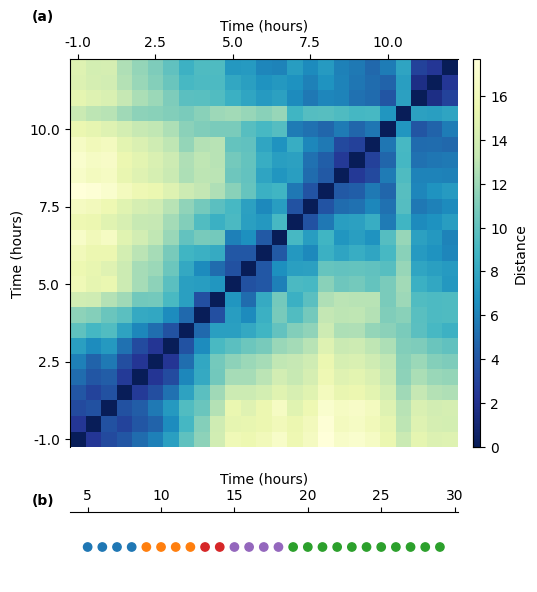

In [29]:
# plot clusters
# drawing.configure_sch_color_map(cm.get_cmap('tab10'))
# sb.set_palette('Dark2', n_colors=8)

gs_kw = dict(width_ratios=[1], height_ratios=[6, 1])

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gs_kw, sharex=False, figsize=(5, 7))

# distance matrix
im = ax1.imshow(
    distance_matrix.distance_matrix, aspect="equal", origin="lower", cmap="YlGnBu_r"
)
sb.despine(ax=ax1, top=False, bottom=True)

# set time ticks for non-unit time step
tick_labels = [
    times[int(i)] for i in ax1.get_xticks()[1:-1]
]  # [times[int(i)] for i in ax1.get_xticks()]
# [f"{int(tick*t_step)}" for tick in ax1.get_xticks()]
# tick_labels = [f"{int(tick*t_step)}" for tick in ax1.get_xticks()]
# ax1.set_xticks(ticks)
# ax1.set_yticks(ticks)
ax1.set_xticklabels([""] + tick_labels)
ax1.set_yticklabels([""] + tick_labels)
ax1.set_xlabel(f"Time (hours)")

ax1.xaxis.set_label_position("top")
ax1.set_ylabel("Time (hours)")

# clusters
cluster_set.plot(ax=ax2)

sb.despine(ax=ax2, left=True, bottom=True, top=False)
# only way to get rid of spine offset in scatter plot apparently
ax2.set_yticks([])
ax2.set_xlabel(f"Time (hours)")
ax2.xaxis.set_label_position("top")

# plt.subplots_adjust(hspace=-0.1)

# colorbar
cax = fig.add_axes((0, 0, 1, 0.1))
pos1 = ax1.get_position()  # get the original position
pos2 = [
    pos1.x0 + pos1.width + 0.03,
    pos1.y0,
    pos1.width * 0.02,
    pos1.height,
]  # vertical
cax.set_position(pos2)  # set a new position

cb = fig.colorbar(im, cax=cax)
# cb.set_ticks([0, 4, 8])
cb.set_label("Distance")
sb.despine(ax=cax)

# plot_new_events(ax=ax2, ypos=0)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.1,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
# filename = f"{figdir}/distmat_{cluster_set.n_clusters}_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()

In [30]:
# range of numbers of clusters
cluster_sets = pk.ClusterSets.from_distance_matrix(
    distance_matrix, n_max_type, n_max_range, clustering_method
)

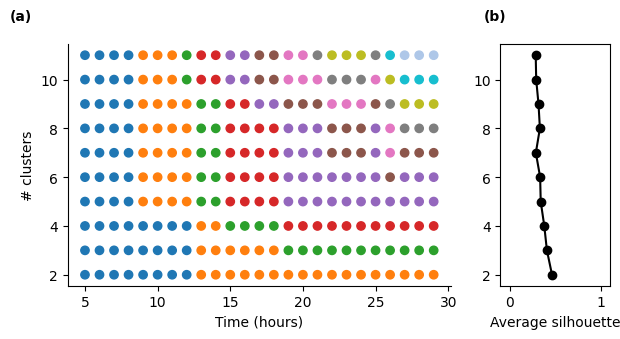

In [31]:
# Plot
gridspec_kw = {"width_ratios": [3.5, 1]}
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7, 3.5), gridspec_kw=gridspec_kw, sharey="all"
)

cluster_sets.plot(axs=(ax1, ax2), with_silhouettes=True, coloring="ascending")

# Format
ax1.set_xlabel(f"Time (hours)")
ax1.set_axisbelow(True)
ax1.set_ylabel("# clusters")

# time_ticks = times
# ax1.set_xticks(time_ticks)
# ax1.set_xticks(time_labels)
time_labels = [str(i) for i in times if i in ax1.get_xticks()]
# ax1.set_xticklabels(time_labels)
sb.despine(ax=ax1)

ax2.set_xlabel("Average silhouette")
ax2.set_xlim((-0.1, 1.1))
ax2.yaxis.set_tick_params(labelleft=True)


# ax3.set_xlabel("Actual # clusters")
# ax3.yaxis.set_tick_params(labelleft=True)

plt.subplots_adjust(wspace=0.2, top=0.8)
# title = f'Clusters and silhouette scores (no thresholding)\n{temporal_network_name}'
# fig.suptitle(title)

# plot_new_events(ax=ax1, ypos=14)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.15,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
# filename = f"{figdir}/phase_clusters_all_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

### Aggregate over clusters, and get ranked list of edge activities

In [32]:
for j in range(5):
    clusters = cluster_sets.clusters[j]
    aggregates = pk.aggregate_network_by_cluster(
        temporal_network, clusters, sort_clusters=False
    )
    n_clusters = len(aggregates)
    print(n_clusters)

    for i in range(len(aggregates)):

        cluster = list(aggregates.keys())[i]
        network = list(aggregates.values())[i][0]
        time_indices = list(aggregates.values())[i][1]
        edge_weights = pk.weighted_edges_as_df(network)
        edge_weights.to_csv(
            f"{outdir}/clusters_{n_clusters}_{i}_timepoints_{time_indices}.csv",
            index=False,
            float_format="%.3f",
        )

2
3
4
5
6


In [33]:
# j = 4
# clusters = cluster_sets.clusters[j]
# aggregates = pk.aggregate_network_by_cluster(temporal_network, clusters, sort_clusters=False)
# n_clusters = len(aggregates)
# print(n_clusters)
# # aggregates

In [34]:
# network = list(aggregates.values())[0][0]
# pk.weighted_edges_as_df(network)

In [35]:
# for i in range(len(aggregates)) :

#     cluster = list(aggregates.keys())[i]
#     network = list(aggregates.values())[i][0]
#     time_indices = list(aggregates.values())[i][1]
#     edge_weights = pk.weighted_edges_as_df(network)
#     edge_weights.to_csv(f"{outdir}/clusters_{n_clusters}_{i}_timepoints_{time_indices}.csv", index=False, float_format='%.3f')

In [36]:
# for label in range(1, n_max+1) :
# #     label = 3 # from 1 to n_max
#     i_label = label - 1
# #     colours = ['blue', 'orange'] # 2 clusters
# #     colours = ['blue', 'orange', 'green'] # 3 clusters
#     colours = ['blue', 'orange', 'green', 'red'] # 4 clusters
#     # colours = ['green', 'purple', 'red', 'blue', 'orange'] # 4 clusters

#     network = aggregated_networks[i_label]

#     dict_weights = sorted(network.edges(data=True), key=lambda t: t[2].get('weight', 1))[::-1]
#     ranking_weights = [f"{'-'.join((i,j))}: {prop['weight']:.2f}" for i,j, prop in dict_weights]
#     # ranking_weights

#     edge_weights = pd.DataFrame([(i,j, dc['weight']) for i,j,dc in network.edges(data=True)], columns=['i', 'j', 'weight'])
#     edge_weights = edge_weights.sort_values(by="weight", axis="index", ascending=False, ignore_index=True)
#     edge_weights = edge_weights.round(3)
#     # edge_weights[edge_weights['weight']>=0.7]
#     edge_weights.to_csv(f"{outdir}/clusters_{n_max}_{colours[i_label]}_timepoints_{cluster_times[label]}.csv", index=False, float_format='%.3f')

# Concentrations time series

In [40]:
times = list(node_series.columns)  # np.array(times)[mask_time]

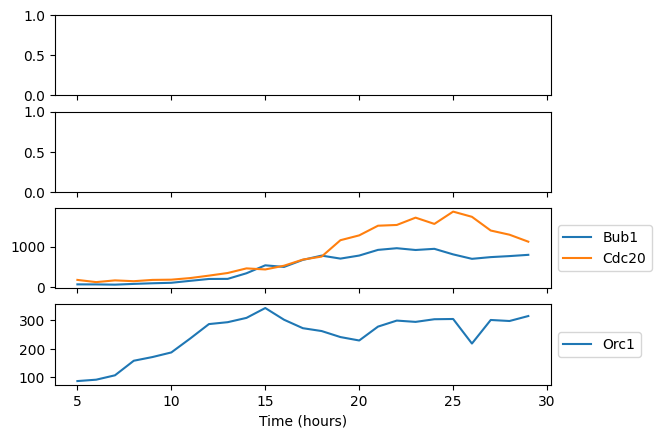

In [44]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

data = pk.TemporalData.from_df(node_series.transpose(), times=times, true_times=times)
data_2 = pk.TemporalData.from_df(
    node_series_2.transpose(), times=times_2, true_times=times_2
)

# data.plot_series(["Cdk1", "Cdk2", "Cdk4", "Cdk6"], add_labels=False, ax=ax1)
# ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# data.plot_series(["Cdc6"], add_labels=False, ax=ax2)
# data_2.plot_series(["Cdc6"], add_labels=False, ax=ax2)

# ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5))

data.plot_series(["Bub1", "Cdc20"], add_labels=False, ax=ax3)
ax3.legend(loc="center left", bbox_to_anchor=(1, 0.5))

data.plot_series(["Orc1"], add_labels=False, ax=ax4)

ax4.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# plot_new_events(ax=ax4, labels=False)

ax4.set_xlabel("Time (hours)")

# plt.savefig(f"{figdir}/mouse_timeseries_full.png", dpi=250, bbox_inches="tight")

plt.show()

In [45]:
node_series.index = node_series.index.astype(str)

24
185212822.141471


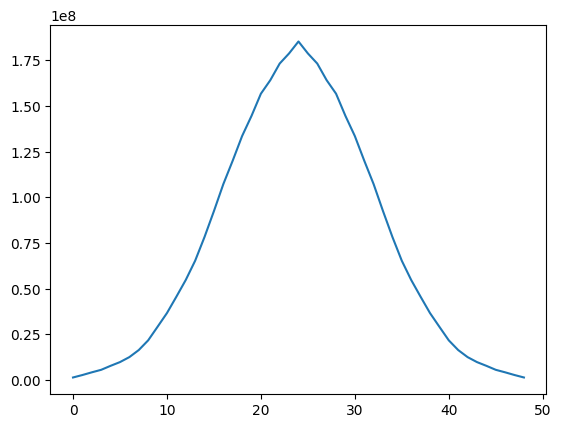

In [46]:
prot = "Cdk1"
ccorr = np.correlate(
    node_series.loc[prot, :].values, node_series.loc[prot, :].values, "full"
)

# print(ccorr)
plt.plot(ccorr)
print(np.argmax(ccorr))
print(max(ccorr))

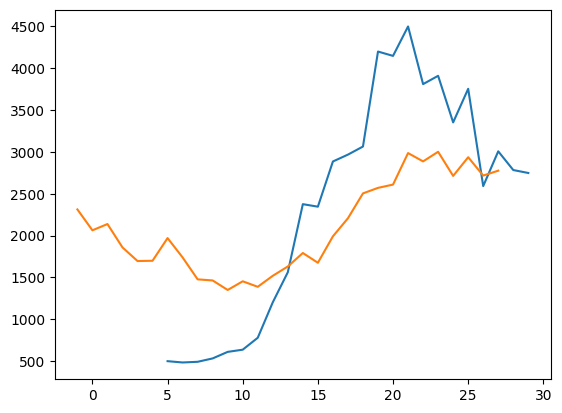

In [47]:
fig, ax = plt.subplots()

ax.plot(node_series.loc[prot, :])
ax.plot(node_series_2.loc[prot, :])